In [ ]:
# Optuna Hyperparameter Optimization for RNA-seq Binary Classification

## Cell 1: Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import pickle
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:

## Cell 2: Load and Prepare Data

In [2]:
# Load your VST-transformed data
# Assume vst_data is a DataFrame with samples as rows, genes as columns
# and labels is a Series with binary classification labels (healthy/unhealthy)

# Replace with your actual data loading
vst_data = pd.read_csv('data/final_vst_normalised_data.csv', index_col=0)  # samples x genes
labels = pd.read_csv('data/simple_metadata_for_pydeseq2.csv', index_col=0)['condition']  # condition column

# Convert string labels to binary (healthy=0, unhealthy=1)
label_mapping = {'healthy': 0, 'unhealthy': 1}
labels = labels.map(label_mapping)

print(f"Data shape: {vst_data.shape}")
print(f"Labels distribution after encoding: {labels.value_counts()}")
print(f"Features (genes): {vst_data.shape[1]}")
print(f"Samples: {vst_data.shape[0]}")

# Basic data validation
assert vst_data.shape[0] == len(labels), "Mismatch between samples and labels"
assert set(labels.unique()) == {0, 1}, "Labels should be binary (0, 1) after encoding"
assert not labels.isnull().any(), "Labels contain missing values"

Data shape: (1895, 58086)
Labels distribution after encoding: condition
0    1000
1     895
Name: count, dtype: int64
Features (genes): 58086
Samples: 1895


In [ ]:
## Drop condition column if it exists in vst_data

In [7]:
if 'condition' in vst_data.columns:
    print("WARNING: Found a 'condition' column in the VST data. This is unexpected and will be dropped before optimization.")
    vst_data.drop(columns=['condition'], inplace=True)
    print(f"Shape of VST data after dropping 'condition' column: {vst_data.shape}")

Shape of VST data after dropping 'condition' column: (1895, 58085)


In [ ]:
## Cell 3: Define Objective Function

In [4]:
def objective(trial):
    """
    Objective function for Optuna optimization.
    This function will be called for each trial to evaluate hyperparameter combinations.
    """

    # 1. Feature Selection Hyperparameters
    variance_threshold = trial.suggest_float('variance_threshold', 0.0, 1.0)
    n_features = trial.suggest_int('n_features', 500, min(8000, vst_data.shape[1]))

    # 1.5. Feature selection method
    feature_selector = trial.suggest_categorical('feature_selector', ['f_classif', 'mutual_info_classif'])

    # 2. Model Selection
    classifier_name = trial.suggest_categorical('classifier',
                                              ['xgboost', 'lightgbm', 'random_forest'])

    # 3. Preprocessing
    use_scaling = trial.suggest_categorical('use_scaling', [True, False])

    # 4. Class imbalance handling
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # 5. Model-specific hyperparameters
    if classifier_name == 'xgboost':
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)

        # Handle class imbalance for XGBoost
        if class_weight == 'balanced':
            scale_pos_weight = len(labels[labels == 0]) / len(labels[labels == 1])
        else:
            scale_pos_weight = 1

        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='logloss'
        )

    elif classifier_name == 'lightgbm':
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
        num_leaves = trial.suggest_int('num_leaves', 10, 100)

        # Handle class imbalance for LightGBM
        if class_weight == 'balanced':
            class_weight_dict = 'balanced'
        else:
            class_weight_dict = None

        classifier = LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            num_leaves=num_leaves,
            class_weight=class_weight_dict,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=-1
        )

    elif classifier_name == 'random_forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

        classifier = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            class_weight=class_weight,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    # 6. Build pipeline
    pipeline_steps = []

    # Add variance threshold filter
    pipeline_steps.append(('variance_filter', VarianceThreshold(threshold=variance_threshold)))

    # Add feature selection
    if feature_selector == 'f_classif':
        selector = SelectKBest(f_classif, k=n_features)
    else:
        selector = SelectKBest(mutual_info_classif, k=n_features)
    pipeline_steps.append(('feature_selection', selector))

    # Add scaling if selected
    if use_scaling:
        pipeline_steps.append(('scaler', StandardScaler()))

    # Add classifier
    pipeline_steps.append(('classifier', classifier))

    # Create pipeline
    pipeline = Pipeline(pipeline_steps)

    # 7. Cross-validation with multiple metrics (reduced for memory)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

    try:
        # Get comprehensive metrics
        scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
        cv_results = cross_validate(pipeline, vst_data, labels,
                                   cv=cv, scoring=scoring, n_jobs=-1)

        # Store additional metrics as user attributes
        trial.set_user_attr('accuracy', cv_results['test_accuracy'].mean())
        trial.set_user_attr('precision', cv_results['test_precision'].mean())
        trial.set_user_attr('recall', cv_results['test_recall'].mean())
        trial.set_user_attr('f1', cv_results['test_f1'].mean())

        # Return mean AUC score (primary metric)
        return cv_results['test_roc_auc'].mean()

    except Exception as e:
        # Return a poor score if the configuration fails
        print(f"Trial failed with error: {e}")
        return 0.0

print("Objective function defined!")

Objective function defined!


In [ ]:
## Cell 4: Configure and Run Optuna Study

In [11]:
# Configure Optuna study
study_name = 'rna_seq_binary_classification'
storage_name = f'sqlite:///{study_name}.db'

# Create study
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='maximize',  # We want to maximize AUC
    sampler=TPESampler(seed=RANDOM_STATE),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
    load_if_exists=True  # Continue from existing study if it exists
)

print(f"Study created: {study_name}")
print(f"Storage: {storage_name}")

[I 2025-06-14 22:39:40,415] A new study created in RDB with name: rna_seq_binary_classification


Study created: rna_seq_binary_classification
Storage: sqlite:///rna_seq_binary_classification.db


In [ ]:
## Cell 5: Execute Optimization

In [12]:
# Run optimization
N_TRIALS = 30  # Adjust based on your computational resources and time

print(f"Starting optimization with {N_TRIALS} trials...")
print("This may take some time depending on your dataset size and number of trials.")

# Optimize
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Optimization completed!")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best AUC score: {study.best_value:.4f}")

Starting optimization with 30 trials...
This may take some time depending on your dataset size and number of trials.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-14 22:40:07,682] Trial 0 finished with value: 1.0 and parameters: {'variance_threshold': 0.3745401188473625, 'n_features': 7631, 'feature_selector': 'f_classif', 'classifier': 'xgboost', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 488, 'max_depth': 9, 'learning_rate': 0.020589728197687916, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032189e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:40:10,347] Trial 1 finished with value: 1.0 and parameters: {'variance_threshold': 0.43194501864211576, 'n_features': 2684, 'feature_selector': 'f_classif', 'classifier': 'random_forest', 'use_scaling': True, 'class_weight': None, 'n_estimators': 118, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:40:14,340] Trial 2 finished with value: 1.0 and parameters: {'variance_threshold': 0.3046137691733707, 'n_features': 1232, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 308, 'max_depth': 7, 'learning_rate': 0.01875220945578641, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 2.8542399074977594, 'reg_lambda': 1.1309571585271492, 'num_leaves': 64}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:40:17,432] Trial 3 finished with value: 1.0 and parameters: {'variance_threshold': 0.9218742350231168, 'n_features': 1163, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': None, 'n_estimators': 156, 'max_depth': 9, 'learning_rate': 0.012886065671894011, 'subsample': 0.9947547746402069, 'colsample_bytree': 0.908897907718663, 'reg_alpha': 6.143857495033091e-07, 'reg_lambda': 1.1212412169964432e-08, 'num_leaves': 84}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:40:39,955] Trial 4 finished with value: 1.0 and parameters: {'variance_threshold': 0.7068573438476171, 'n_features': 5968, 'feature_selector': 'f_classif', 'classifier': 'random_forest', 'use_scaling': True, 'class_weight': None, 'n_estimators': 230, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:40:57,262] Trial 5 finished with value: 1.0 and parameters: {'variance_thresho

/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:41:02,369] Trial 6 finished with value: 0.9999933043411304 and parameters: {'variance_threshold': 0.289751452913768, 'n_features': 1709, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': False, 'class_weight': None, 'n_estimators': 459, 'max_depth': 5, 'learning_rate': 0.014539853705640319, 'subsample': 0.6911740650167767, 'colsample_bytree': 0.7708431154505025, 'reg_alpha': 0.2302146162075984, 'reg_lambda': 0.5579242641506352, 'num_leaves': 10}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:41:07,214] Trial 7 finished with value: 0.9999933043411304 and parameters: {'variance_threshold': 0.5107473025775657, 'n_features': 3630, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': False, 'class_weight': None, 'n_estimators': 485, 'max_depth': 5, 'learning_rate': 0.05426206745606973, 'subsample': 0.7203513239267079, 'colsample_bytree': 0.713936197750987, 'reg_alpha': 2.147744058054667e-08, 'reg_lambda': 0.0030625205094643145, 'num_leaves': 55}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:41:26,898] Trial 8 finished with value: 1.0 and parameters: {'variance_threshold': 0.05147875124998935, 'n_features': 2590, 'feature_selector': 'f_classif', 'classifier': 'random_forest', 'use_scaling': False, 'class_weight': 'balanced', 'n_estimators': 392, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:43:03,511] Trial 9 finished with value: 1.0 and paramete

/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:49:43,018] Trial 21 finished with value: 1.0 and parameters: {'variance_threshold': 0.3647669177947605, 'n_features': 2074, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.023195623005266248, 'subsample': 0.998288042698449, 'colsample_bytree': 0.8661559325962194, 'reg_alpha': 0.047300839911389135, 'reg_lambda': 7.66055179018752, 'num_leaves': 61}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:49:46,138] Trial 22 finished with value: 1.0 and parameters: {'variance_threshold': 0.2473558935612773, 'n_features': 665, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 436, 'max_depth': 7, 'learning_rate': 0.010534650950082523, 'subsample': 0.9182660471967535, 'colsample_bytree': 0.9887126273626139, 'reg_alpha': 3.285711757143394e-08, 'reg_lambda': 0.03566387164460292, 'num_leaves': 43}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:49:50,497] Trial 23 finished with value: 1.0 and parameters: {'variance_threshold': 0.45303262472921635, 'n_features': 3651, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 264, 'max_depth': 6, 'learning_rate': 0.09152161800945911, 'subsample': 0.8065906724989261, 'colsample_bytree': 0.7994804659539927, 'reg_alpha': 4.54309370276969, 'reg_lambda': 0.00010713477042900469, 'num_leaves': 98}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:49:53,408] Trial 24 finished with value: 1.0 and parameters: {'variance_threshold': 0.5689554884391748, 'n_features': 1219, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 143, 'max_depth': 8, 'learning_rate': 0.022705153552328928, 'subsample': 0.9249081653983519, 'colsample_bytree': 0.8595849191581005, 'reg_alpha': 1.591320623245741e-05, 'reg_lambda': 0.083433321802498, 'num_leaves': 21}. Best is trial 0 with value: 1.0.


/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:49:56,771] Trial 25 finished with value: 1.0 and parameters: {'variance_threshold': 0.19426711275796738, 'n_features': 2458, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 218, 'max_depth': 4, 'learning_rate': 0.0367480457875785, 'subsample': 0.8060987139203102, 'colsample_bytree': 0.9490318926411205, 'reg_alpha': 0.001505465154104983, 'reg_lambda': 0.003243030204840277, 'num_leaves': 74}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:51:36,277] Trial 26 finished with value: 1.0 and parameters: {'variance_threshold': 0.3240599697461399, 'n_features': 3360, 'feature_selector': 'mutual_info_classif', 'classifier': 'xgboost', 'use_scaling': False, 'class_weight': None, 'n_estimators': 340, 'max_depth': 8, 'learning_rate': 0.017724612648609816, 'subsample': 0.6535711551007728, 'colsample_bytree': 0.7686564000341465, 'reg_alpha': 3.201144217844586e-07, 'reg_lambda': 5.793975991728809}. Best is 

/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/boystroo/PycharmProjects/XAIForB-ALL-good/.venv1/lib/

[I 2025-06-14 22:51:40,704] Trial 27 finished with value: 1.0 and parameters: {'variance_threshold': 0.4243426828021651, 'n_features': 4601, 'feature_selector': 'f_classif', 'classifier': 'lightgbm', 'use_scaling': True, 'class_weight': 'balanced', 'n_estimators': 290, 'max_depth': 7, 'learning_rate': 0.08687092260359813, 'subsample': 0.9442602078027229, 'colsample_bytree': 0.8427504552916896, 'reg_alpha': 0.39773688078321034, 'reg_lambda': 2.6169664122696604e-07, 'num_leaves': 38}. Best is trial 0 with value: 1.0.
[I 2025-06-14 22:51:44,765] Trial 28 finished with value: 1.0 and parameters: {'variance_threshold': 0.10775290993717757, 'n_features': 1233, 'feature_selector': 'f_classif', 'classifier': 'xgboost', 'use_scaling': True, 'class_weight': None, 'n_estimators': 208, 'max_depth': 6, 'learning_rate': 0.028159632431500187, 'subsample': 0.8603297537102066, 'colsample_bytree': 0.6065948274718582, 'reg_alpha': 9.712340981387267e-05, 'reg_lambda': 5.71248181506669e-05}. Best is trial 

In [ ]:
## Cell 6: Analyze Results


In [ ]:
# Get best parameters
best_params = study.best_params
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Get best trial details
best_trial = study.best_trial
print(f"\nBest trial:")
print(f"  Value (AUC): {best_trial.value:.4f}")
print(f"  Number: {best_trial.number}")

# Show optimization history
trials_df = study.trials_dataframe()
print(f"\nTrials summary:")
print(f"  Total trials: {len(trials_df)}")
print(f"  Completed trials: {len(trials_df[trials_df['state'] == 'COMPLETE'])}")
print(f"  Failed trials: {len(trials_df[trials_df['state'] == 'FAIL'])}")

# Basic statistics
if len(trials_df[trials_df['state'] == 'COMPLETE']) > 0:
    completed_values = trials_df[trials_df['state'] == 'COMPLETE']['value']
    print(f"  Mean AUC: {completed_values.mean():.4f}")
    print(f"  Std AUC: {completed_values.std():.4f}")
    print(f"  Min AUC: {completed_values.min():.4f}")
    print(f"  Max AUC: {completed_values.max():.4f}")

In [ ]:
## Cell 7: Save Optimization Results

In [ ]:
# Save the complete study for later analysis
study_file = f'{study_name}_complete_study.pkl'
with open(study_file, 'wb') as f:
    pickle.dump(study, f)

# Save best parameters separately for easy loading
best_params_file = f'{study_name}_best_params.pkl'
with open(best_params_file, 'wb') as f:
    pickle.dump(best_params, f)

# Save as JSON for human readability
import json
best_params_json = f'{study_name}_best_params.json'
with open(best_params_json, 'w') as f:
    json.dump(best_params, f, indent=2)

# Save trials dataframe
trials_csv = f'{study_name}_trials.csv'
trials_df.to_csv(trials_csv, index=False)

print("Files saved:")
print(f"  Complete study: {study_file}")
print(f"  Best parameters (pickle): {best_params_file}")
print(f"  Best parameters (JSON): {best_params_json}")
print(f"  All trials: {trials_csv}")

In [ ]:
## Cell 8: Create Optimized Pipeline for Export

In [ ]:
# Reconstruct the best pipeline for training in another notebook
def create_optimized_pipeline(best_params):
    """
    Create the optimized pipeline based on best parameters.
    This function can be imported and used in the training notebook.
    """

    # Extract parameters
    variance_threshold = best_params['variance_threshold']
    n_features = best_params['n_features']
    feature_selector = best_params['feature_selector']
    classifier_name = best_params['classifier']
    use_scaling = best_params['use_scaling']
    class_weight = best_params['class_weight']

    # Build pipeline steps
    pipeline_steps = []

    # Add variance threshold filter
    pipeline_steps.append(('variance_filter', VarianceThreshold(threshold=variance_threshold)))

    # Add feature selection
    if feature_selector == 'f_classif':
        selector = SelectKBest(f_classif, k=n_features)
    else:
        selector = SelectKBest(mutual_info_classif, k=n_features)
    pipeline_steps.append(('feature_selection', selector))

    # Add scaling if selected
    if use_scaling:
        pipeline_steps.append(('scaler', StandardScaler()))

    # Create classifier based on best parameters
    if classifier_name == 'xgboost':
        # Handle class imbalance for XGBoost
        if class_weight == 'balanced':
            scale_pos_weight = len(labels[labels == 0]) / len(labels[labels == 1])
        else:
            scale_pos_weight = 1

        classifier = XGBClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda'],
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='logloss'
        )
    elif classifier_name == 'lightgbm':
        # Handle class imbalance for LightGBM
        if class_weight == 'balanced':
            class_weight_dict = 'balanced'
        else:
            class_weight_dict = None

        classifier = LGBMClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda'],
            num_leaves=best_params['num_leaves'],
            class_weight=class_weight_dict,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=-1
        )
    elif classifier_name == 'random_forest':
        classifier = RandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            class_weight=class_weight,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    # Add classifier to pipeline
    pipeline_steps.append(('classifier', classifier))

    # Create and return pipeline
    return Pipeline(pipeline_steps)

# Create and save the optimized pipeline
optimized_pipeline = create_optimized_pipeline(best_params)

# Save the pipeline
pipeline_file = f'{study_name}_optimized_pipeline.pkl'
joblib.dump(optimized_pipeline, pipeline_file)

print(f"Optimized pipeline saved: {pipeline_file}")
print(f"Pipeline steps: {[step[0] for step in optimized_pipeline.steps]}")

In [ ]:
## Cell 9: Validation and Summary

In [ ]:
# Quick validation of the optimized pipeline
print("Validating optimized pipeline...")

# Perform one final cross-validation with best parameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
final_scores = cross_val_score(optimized_pipeline, vst_data, labels,
                              cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"Final validation scores (AUC): {final_scores}")
print(f"Mean AUC: {final_scores.mean():.4f} ± {final_scores.std():.4f}")

# Create summary dictionary
optimization_summary = {
    'study_name': study_name,
    'n_trials': len(study.trials),
    'best_score': study.best_value,
    'best_params': best_params,
    'final_validation_mean': final_scores.mean(),
    'final_validation_std': final_scores.std(),
    'data_shape': vst_data.shape,
    'random_state': RANDOM_STATE
}

# Save summary
summary_file = f'{study_name}_summary.pkl'
with open(summary_file, 'wb') as f:
    pickle.dump(optimization_summary, f)

print(f"\nOptimization Summary:")
print(f"  Study: {optimization_summary['study_name']}")
print(f"  Trials completed: {optimization_summary['n_trials']}")
print(f"  Best AUC: {optimization_summary['best_score']:.4f}")
print(f"  Final validation: {optimization_summary['final_validation_mean']:.4f} ± {optimization_summary['final_validation_std']:.4f}")
print(f"  Data shape: {optimization_summary['data_shape']}")

print(f"\nSummary saved: {summary_file}")

In [ ]:
## Cell 10: Files for Next Notebook

In [ ]:
# List all files created for the training notebook
created_files = [
    f'{study_name}_best_params.pkl',
    f'{study_name}_best_params.json',
    f'{study_name}_optimized_pipeline.pkl',
    f'{study_name}_summary.pkl',
    f'{study_name}_complete_study.pkl',
    f'{study_name}_trials.csv'
]

print("Files created for training notebook:")
for file in created_files:
    print(f"  ✓ {file}")

print(f"\nTo use in training notebook:")
print(f"1. Load best parameters: pickle.load(open('{best_params_file}', 'rb'))")
print(f"2. Load optimized pipeline: joblib.load('{pipeline_file}')")
print(f"3. Load summary: pickle.load(open('{summary_file}', 'rb'))")

print(f"\nReady for training phase!")


Data diagnostics:
Healthy samples: 1000
Unhealthy samples: 895
Unique sample sources in data


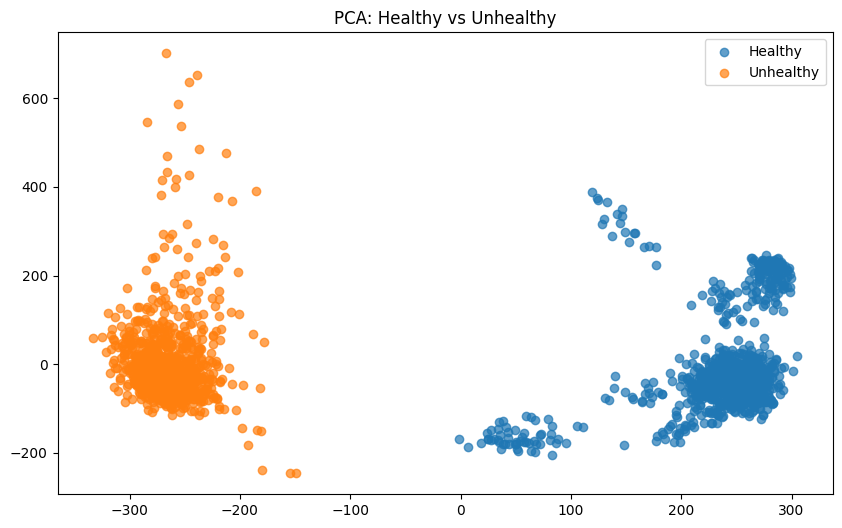

In [13]:
# Add this to a new cell to diagnose:
print("Data diagnostics:")
print(f"Healthy samples: {(labels == 0).sum()}")
print(f"Unhealthy samples: {(labels == 1).sum()}")
print(f"Unique sample sources in data")

# Check for perfect separation
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(vst_data)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[labels==0, 0], pca_data[labels==0, 1], alpha=0.7, label='Healthy')
plt.scatter(pca_data[labels==1, 0], pca_data[labels==1, 1], alpha=0.7, label='Unhealthy')
plt.legend()
plt.title("PCA: Healthy vs Unhealthy")
plt.show()

In [14]:
# Test with a simple train/test split to see if perfect scores persist
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    vst_data, labels, test_size=0.3, stratify=labels, random_state=42
)

# Simple Random Forest test
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Manual test AUC: {test_auc}")

Manual test AUC: 1.0


## Notes for Training Notebook

When you move to the training notebook, you can load the optimized configuration with:

```python
import pickle
import joblib

# Load best parameters
best_params = pickle.load(open('rna_seq_binary_classification_best_params.pkl', 'rb'))

# Load pre-configured optimized pipeline
optimized_pipeline = joblib.load('rna_seq_binary_classification_optimized_pipeline.pkl')

# Load optimization summary
summary = pickle.load(open('rna_seq_binary_classification_summary.pkl', 'rb'))

# Now you can fit the pipeline and apply SHAP analysis
optimized_pipeline.fit(X_train, y_train)
predictions = optimized_pipeline.predict(X_test)
```

The pipeline is ready to use and contains all the optimized preprocessing steps and model configuration.